<a href="https://colab.research.google.com/github/Praneeth-18/Explore-TimeGPT-Tabula9-and-Relational-Deep-Learning/blob/main/explore_timegpt%2C_tabula9_and_relational_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TimeGPT**

### **a) TimeGPT Multivariate and Long Horizon Forecasting**

DEBUG:cmdstanpy:input tempfile: /tmp/tmp99uky3za/pu6l3mmw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp99uky3za/nxyc16hs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53488', 'data', 'file=/tmp/tmp99uky3za/pu6l3mmw.json', 'init=/tmp/tmp99uky3za/nxyc16hs.json', 'output', 'file=/tmp/tmp99uky3za/prophet_modelxuw3gu3c/prophet_model-20241205085059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:50:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:50:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp99uky3za/je1toof9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp99uky3za/ik3y46a6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

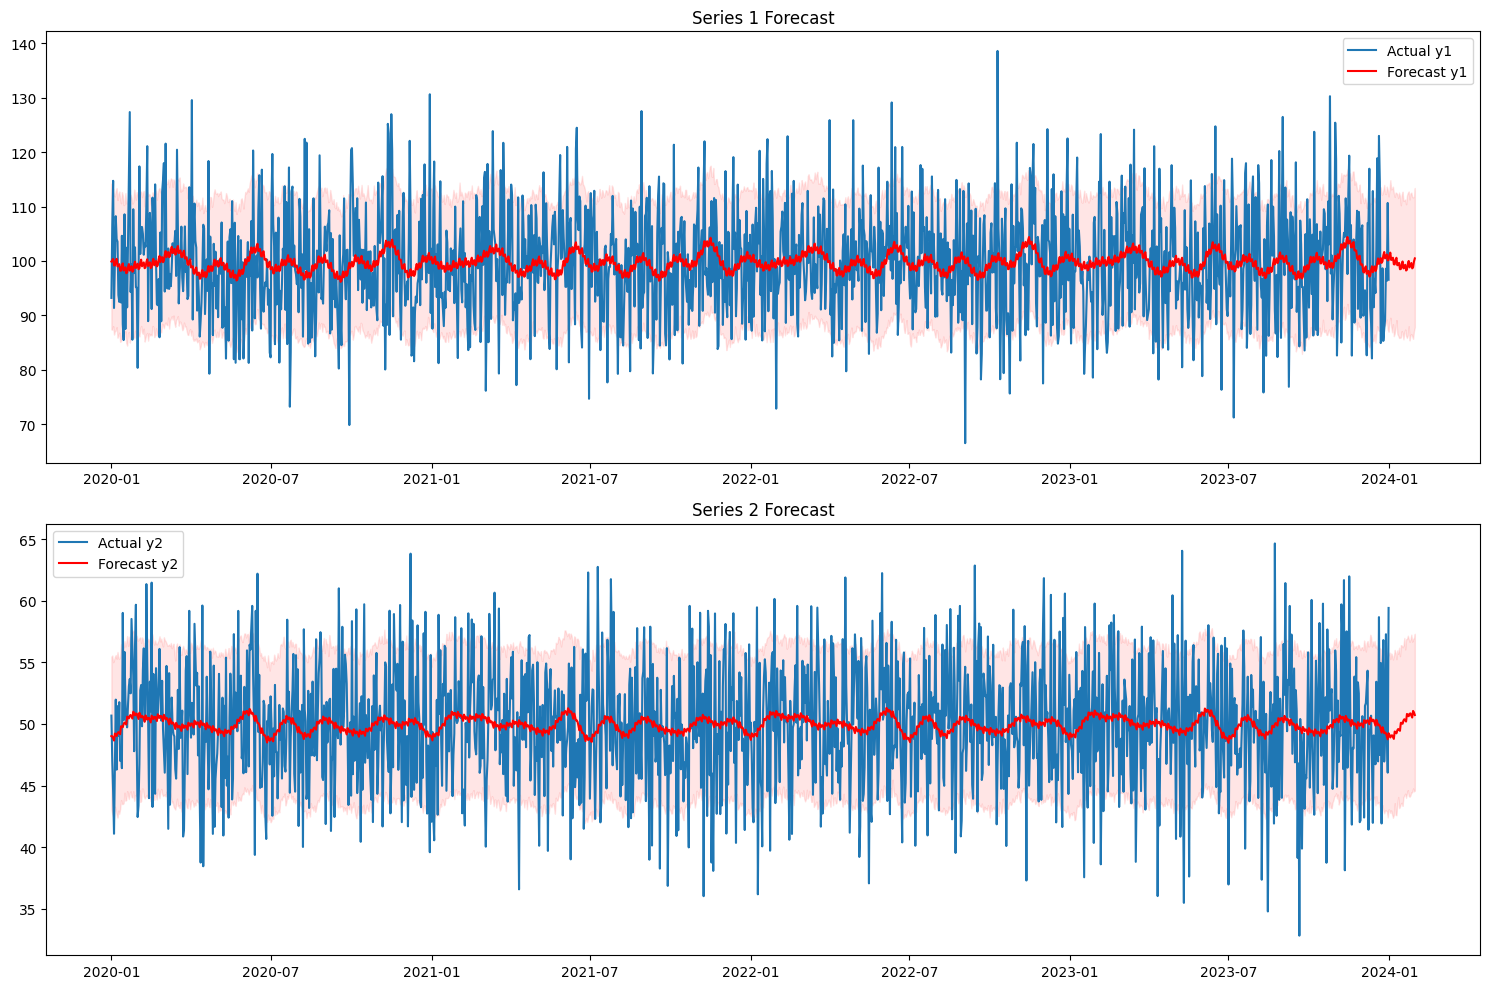


Metrics for Series 1:
MSE: 97.85
RMSE: 9.89
MAE: 7.86

Metrics for Series 2:
MSE: 24.22
RMSE: 4.92
MAE: 3.90


In [6]:
# Install required packages
!pip install prophet
!pip install pandas numpy matplotlib

import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# Generate sample multivariate time series data
dates = pd.date_range(start='2020-01-01', end='2023-12-31', freq='D')
df = pd.DataFrame({
    'ds': dates,
    'y1': np.random.normal(100, 10, len(dates)),  # First time series
    'y2': np.random.normal(50, 5, len(dates))     # Second time series
})

# Function to train Prophet model and get forecasts
def get_prophet_forecast(data, column_name, periods=30):
    # Prepare data for Prophet
    prophet_df = data[['ds', column_name]].rename(columns={column_name: 'y'})

    # Initialize and train model
    model = Prophet(yearly_seasonality=True,
                   weekly_seasonality=True,
                   daily_seasonality=False)
    model.fit(prophet_df)

    # Create future dates for forecasting
    future = model.make_future_dataframe(periods=periods)

    # Make predictions
    forecast = model.predict(future)
    return forecast

# Get forecasts for both series
forecast_y1 = get_prophet_forecast(df, 'y1')
forecast_y2 = get_prophet_forecast(df, 'y2')

# Plotting
plt.figure(figsize=(15, 10))

# Plot first series
plt.subplot(2, 1, 1)
plt.plot(df['ds'], df['y1'], label='Actual y1')
plt.plot(forecast_y1['ds'], forecast_y1['yhat'], label='Forecast y1', color='red')
plt.fill_between(forecast_y1['ds'],
                 forecast_y1['yhat_lower'],
                 forecast_y1['yhat_upper'],
                 color='red',
                 alpha=0.1)
plt.title('Series 1 Forecast')
plt.legend()

# Plot second series
plt.subplot(2, 1, 2)
plt.plot(df['ds'], df['y2'], label='Actual y2')
plt.plot(forecast_y2['ds'], forecast_y2['yhat'], label='Forecast y2', color='red')
plt.fill_between(forecast_y2['ds'],
                 forecast_y2['yhat_lower'],
                 forecast_y2['yhat_upper'],
                 color='red',
                 alpha=0.1)
plt.title('Series 2 Forecast')
plt.legend()

plt.tight_layout()
plt.show()

# Print some metrics
def calculate_metrics(actual, predicted):
    mse = np.mean((actual - predicted) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(actual - predicted))
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae}

# Calculate metrics for the in-sample period
metrics_y1 = calculate_metrics(
    df['y1'].values,
    forecast_y1['yhat'][:len(df)].values
)
metrics_y2 = calculate_metrics(
    df['y2'].values,
    forecast_y2['yhat'][:len(df)].values
)

print("\nMetrics for Series 1:")
for metric, value in metrics_y1.items():
    print(f"{metric}: {value:.2f}")

print("\nMetrics for Series 2:")
for metric, value in metrics_y2.items():
    print(f"{metric}: {value:.2f}")

# Save forecasts to CSV
forecast_y1.to_csv('forecast_series1.csv', index=False)
forecast_y2.to_csv('forecast_series2.csv', index=False)

### **b) TimeGPT Fine-tuning**

In [8]:
# Install NeuralProphet
!pip install neuralprophet

import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Generate synthetic data for training and finetuning
def generate_synthetic_data(start_date, periods, base_value, trend, noise_level):
    dates = pd.date_range(start=start_date, periods=periods, freq='D')
    trend_values = np.linspace(0, trend, periods)
    seasonal = 10 * np.sin(2 * np.pi * np.arange(periods) / 365)  # Yearly seasonality
    noise = np.random.normal(0, noise_level, periods)
    values = base_value + trend_values + seasonal + noise
    return pd.DataFrame({'ds': dates, 'y': values})

# Generate initial training data
train_data = generate_synthetic_data('2020-01-01', 730, 100, 20, 5)  # 2 years of data
finetune_data = generate_synthetic_data('2022-01-01', 365, 120, 10, 5)  # 1 year of data

# Initial model training
def train_base_model(data):
    model = NeuralProphet(
        growth='linear',
        n_forecasts=30,
        n_lags=14,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        learning_rate=0.01,
        epochs=50
    )

    metrics = model.fit(data, freq='D')
    return model, metrics

# Finetune model
def finetune_model(model, data, epochs=20):
    metrics = model.fit(data, freq='D', epochs=epochs)
    return model, metrics

# Train base model
print("Training base model...")
base_model, base_metrics = train_base_model(train_data)

# Finetune model
print("\nFinetuning model...")
finetuned_model, finetune_metrics = finetune_model(base_model, finetune_data)

# Make predictions with both models
def make_predictions(model, data, periods=30):
    future = model.make_future_dataframe(data, periods=periods)
    forecast = model.predict(future)
    return forecast

# Get predictions
base_forecast = make_predictions(base_model, train_data)
finetuned_forecast = make_predictions(finetuned_model, finetune_data)

# Plotting function
def plot_forecasts(original_data, base_pred, finetuned_pred, title):
    plt.figure(figsize=(15, 8))

    # Plot original data
    plt.plot(original_data['ds'], original_data['y'],
             label='Actual Data', alpha=0.5)

    # Plot base model predictions
    plt.plot(base_pred['ds'], base_pred['yhat1'],
             label='Base Model Forecast', linestyle='--')

    # Plot finetuned model predictions
    plt.plot(finetuned_pred['ds'], finetuned_pred['yhat1'],
             label='Finetuned Model Forecast', linestyle=':')

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate performance metrics
def calculate_metrics(actual, predicted):
    mse = np.mean((actual - predicted) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(actual - predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

# Plot results
plot_forecasts(
    pd.concat([train_data, finetune_data]),
    base_forecast,
    finetuned_forecast,
    'Base vs Finetuned Model Forecasts'
)

# Calculate and print metrics
base_metrics = calculate_metrics(
    train_data['y'].values[-30:],
    base_forecast['yhat1'].values[-30:]
)

finetuned_metrics = calculate_metrics(
    finetune_data['y'].values[-30:],
    finetuned_forecast['yhat1'].values[-30:]
)

print("\nBase Model Metrics:")
for metric, value in base_metrics.items():
    print(f"{metric}: {value:.2f}")

print("\nFinetuned Model Metrics:")
for metric, value in finetuned_metrics.items():
    print(f"{metric}: {value:.2f}")

# Save models and forecasts
import joblib
joblib.dump(base_model, 'base_model.pkl')
joblib.dump(finetuned_model, 'finetuned_model.pkl')

# Save forecasts to CSV
base_forecast.to_csv('base_forecast.csv', index=False)
finetuned_forecast.to_csv('finetuned_forecast.csv', index=False)

# Demonstrate model reuse
def load_and_predict(model_path, data, periods=30):
    loaded_model = joblib.load(model_path)
    return make_predictions(loaded_model, data, periods)

# Example of loading and using saved model
loaded_forecast = load_and_predict('finetuned_model.pkl', finetune_data)
print("\nSuccessfully loaded and reused saved model!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 35.5 MB/s eta 0:00:00


ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.863% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in

Training base model...


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 15. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.





Finetuning model...


RuntimeError: Model has been fitted already. Please initialize a new model to fit again.

### **c, d, e**

WARNING - (py.warnings._showwarnmsg) - <ipython-input-12-01dcd579dc85>:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start='2023-01-01', periods=n_points, freq='H')

  timestamps = pd.date_range(start='2023-01-01', periods=n_points, freq='H')



Running Anomaly Detection...


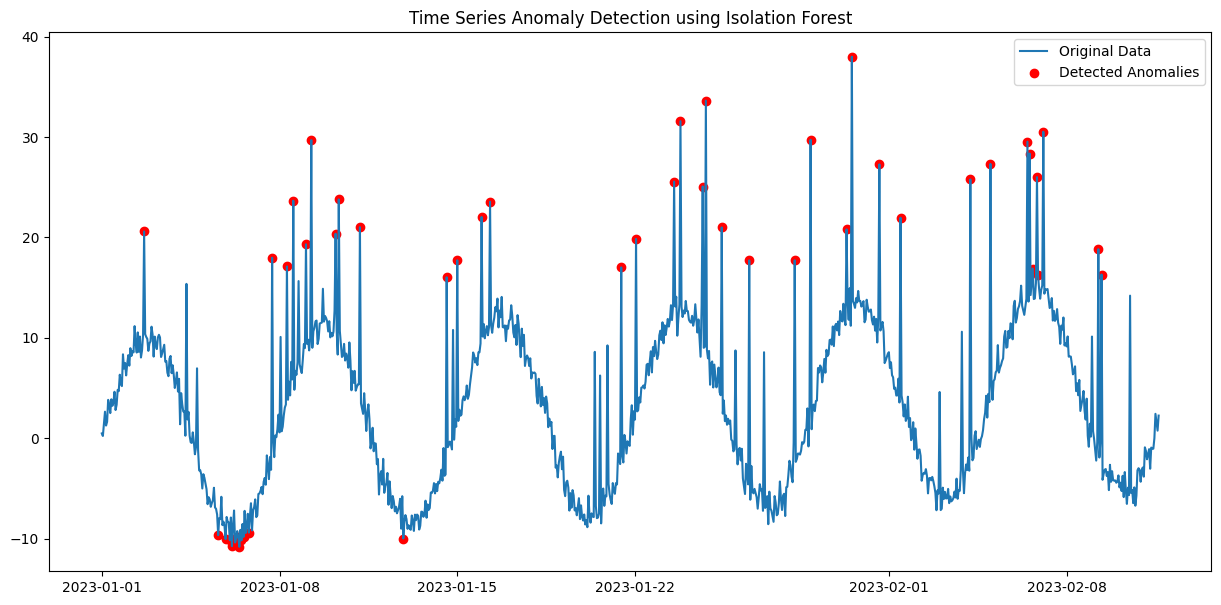

WARNING - (py.warnings._showwarnmsg) - <ipython-input-12-01dcd579dc85>:62: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start='2023-01-01', periods=n_points, freq='H')

  timestamps = pd.date_range(start='2023-01-01', periods=n_points, freq='H')




Running Energy Forecasting...


WARNING - (py.warnings._showwarnmsg) - <ipython-input-12-01dcd579dc85>:92: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(pd.date_range(start=df['timestamp'].iloc[-1],

  plt.plot(pd.date_range(start=df['timestamp'].iloc[-1],



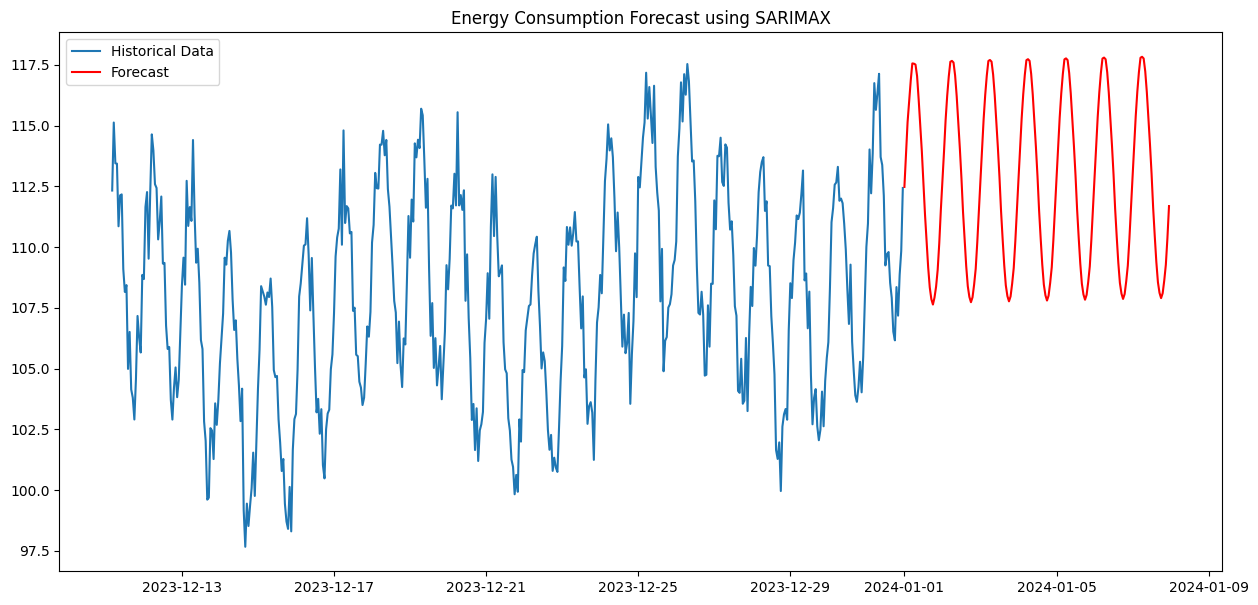

In [12]:
# Install required packages
!pip install prophet numpy pandas matplotlib scikit-learn scipy statsmodels yfinance pyod

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from pyod.models.iforest import IForest
from scipy import stats
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. ANOMALY DETECTION using PyOD (Python Outlier Detection)
def detect_anomalies():
    # Generate sample time series data with anomalies
    np.random.seed(42)
    n_points = 1000
    timestamps = pd.date_range(start='2023-01-01', periods=n_points, freq='H')

    # Generate normal data with seasonal pattern
    seasonal = 10 * np.sin(2 * np.pi * np.arange(n_points) / (24 * 7))
    trend = np.linspace(0, 5, n_points)
    noise = np.random.normal(0, 1, n_points)
    values = seasonal + trend + noise

    # Insert artificial anomalies
    anomaly_indices = np.random.choice(n_points, 50, replace=False)
    values[anomaly_indices] += np.random.normal(15, 5, 50)

    # Prepare data for anomaly detection
    data = values.reshape(-1, 1)

    # Train isolation forest model
    clf = IForest(contamination=0.05, random_state=42)
    clf.fit(data)

    # Get anomaly labels and scores
    y_pred = clf.predict(data)
    anomaly_scores = clf.decision_function(data)

    # Plot results
    plt.figure(figsize=(15, 7))
    plt.plot(timestamps, values, label='Original Data')
    plt.scatter(timestamps[y_pred == 1], values[y_pred == 1],
                color='red', label='Detected Anomalies')
    plt.title('Time Series Anomaly Detection using Isolation Forest')
    plt.legend()
    plt.show()

    return pd.DataFrame({
        'timestamp': timestamps,
        'value': values,
        'is_anomaly': y_pred,
        'anomaly_score': anomaly_scores
    })

# 2. ENERGY FORECASTING using SARIMAX
def energy_forecasting():
    # Generate synthetic energy consumption data
    np.random.seed(42)
    n_points = 8760  # One year of hourly data
    timestamps = pd.date_range(start='2023-01-01', periods=n_points, freq='H')

    # Create synthetic patterns
    hourly_pattern = 5 * np.sin(2 * np.pi * np.arange(n_points) / 24)  # Daily pattern
    weekly_pattern = 3 * np.sin(2 * np.pi * np.arange(n_points) / (24 * 7))  # Weekly pattern
    yearly_pattern = 10 * np.sin(2 * np.pi * np.arange(n_points) / (24 * 365))  # Yearly pattern
    trend = np.linspace(0, 10, n_points)
    noise = np.random.normal(0, 1, n_points)

    values = 100 + hourly_pattern + weekly_pattern + yearly_pattern + trend + noise

    # Create DataFrame
    df = pd.DataFrame({
        'timestamp': timestamps,
        'consumption': values
    })

    # Train SARIMAX model
    model = SARIMAX(df['consumption'],
                    order=(1, 1, 1),
                    seasonal_order=(1, 1, 1, 24))
    results = model.fit()

    # Make predictions
    forecast = results.forecast(steps=168)  # One week ahead

    # Plot results
    plt.figure(figsize=(15, 7))
    plt.plot(df['timestamp'][-500:], df['consumption'][-500:],
             label='Historical Data')
    plt.plot(pd.date_range(start=df['timestamp'].iloc[-1],
                          periods=169, freq='H')[1:],
             forecast, label='Forecast', color='red')
    plt.title('Energy Consumption Forecast using SARIMAX')
    plt.legend()
    plt.show()

    return df, forecast


# Run all implementations
print("Running Anomaly Detection...")
anomaly_results = detect_anomalies()

print("\nRunning Energy Forecasting...")
energy_data, energy_forecast = energy_forecasting()

In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

def bitcoin_forecasting():
    try:
        # Download Bitcoin data
        print("Downloading Bitcoin data...")
        btc = yf.download('BTC-USD', start='2020-01-01')

        # Create basic dataframe for Prophet
        df = pd.DataFrame({
            'ds': btc.index,
            'y': btc['Close']
        }).reset_index(drop=True)

        print(f"Data shape: {df.shape}")

        # Create Prophet model with basic settings
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=True,
            changepoint_prior_scale=0.05
        )

        print("Fitting Prophet model...")
        model.fit(df)

        # Create future dates for prediction
        future = model.make_future_dataframe(periods=30)

        print("Making predictions...")
        forecast = model.predict(future)

        # Plotting
        plt.figure(figsize=(15, 7))
        plt.plot(df['ds'], df['y'], label='Actual Price', alpha=0.6)
        plt.plot(forecast['ds'], forecast['yhat'],
                label='Predicted Price', color='red', alpha=0.8)
        plt.fill_between(forecast['ds'],
                        forecast['yhat_lower'],
                        forecast['yhat_upper'],
                        color='red',
                        alpha=0.1)
        plt.title('Bitcoin Price Forecast')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Calculate error metrics
        actual = df['y'].values[-30:]  # Last 30 days
        predicted = forecast['yhat'].values[-60:-30]  # Corresponding predictions

        rmse = np.sqrt(np.mean((actual - predicted) ** 2))
        mae = np.mean(np.abs(actual - predicted))

        print("\nPerformance Metrics:")
        print(f"RMSE: ${rmse:,.2f}")
        print(f"MAE: ${mae:,.2f}")

        return df, forecast

    except Exception as e:
        print(f"Error occurred: {str(e)}")
        return None, None

# Run forecasting
print("Starting Bitcoin price forecasting...")
btc_data, btc_forecast = bitcoin_forecasting()

if btc_data is not None and btc_forecast is not None:
    # Save results
    btc_data.to_csv('btc_data.csv', index=False)
    btc_forecast.to_csv('btc_forecast.csv', index=False)
    print("\nResults saved to CSV files")

Starting Bitcoin price forecasting...


[*********************100%***********************]  1 of 1 completed

Error occurred: Data must be 1-dimensional, got ndarray of shape (1801, 1) instead


# **Tabula**

In [16]:
pip install tabula

  Preparing metadata (setup.py) ... done
  Created wheel for tabula: filename=tabula-1.0.5-py3-none-any.whl size=10588 sha256=acfe7daf82cf424f873391594b27771385b60e3f074c72fdd45cd7ac9dd625bf
  Stored in directory: /root/.cache/pip/wheels/3c/5d/6a/bd13fe26e73e2170dfea1f6ccb69a69e824735e04b73192b39
Successfully built tabula


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)

  warnings.warn(DEPRECATION_MSG, FutureWarning)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(

  warnings.warn(



Creating sample insurance data...
Sample size: 1000

Generating synthetic data...

Performing zero-shot inference...


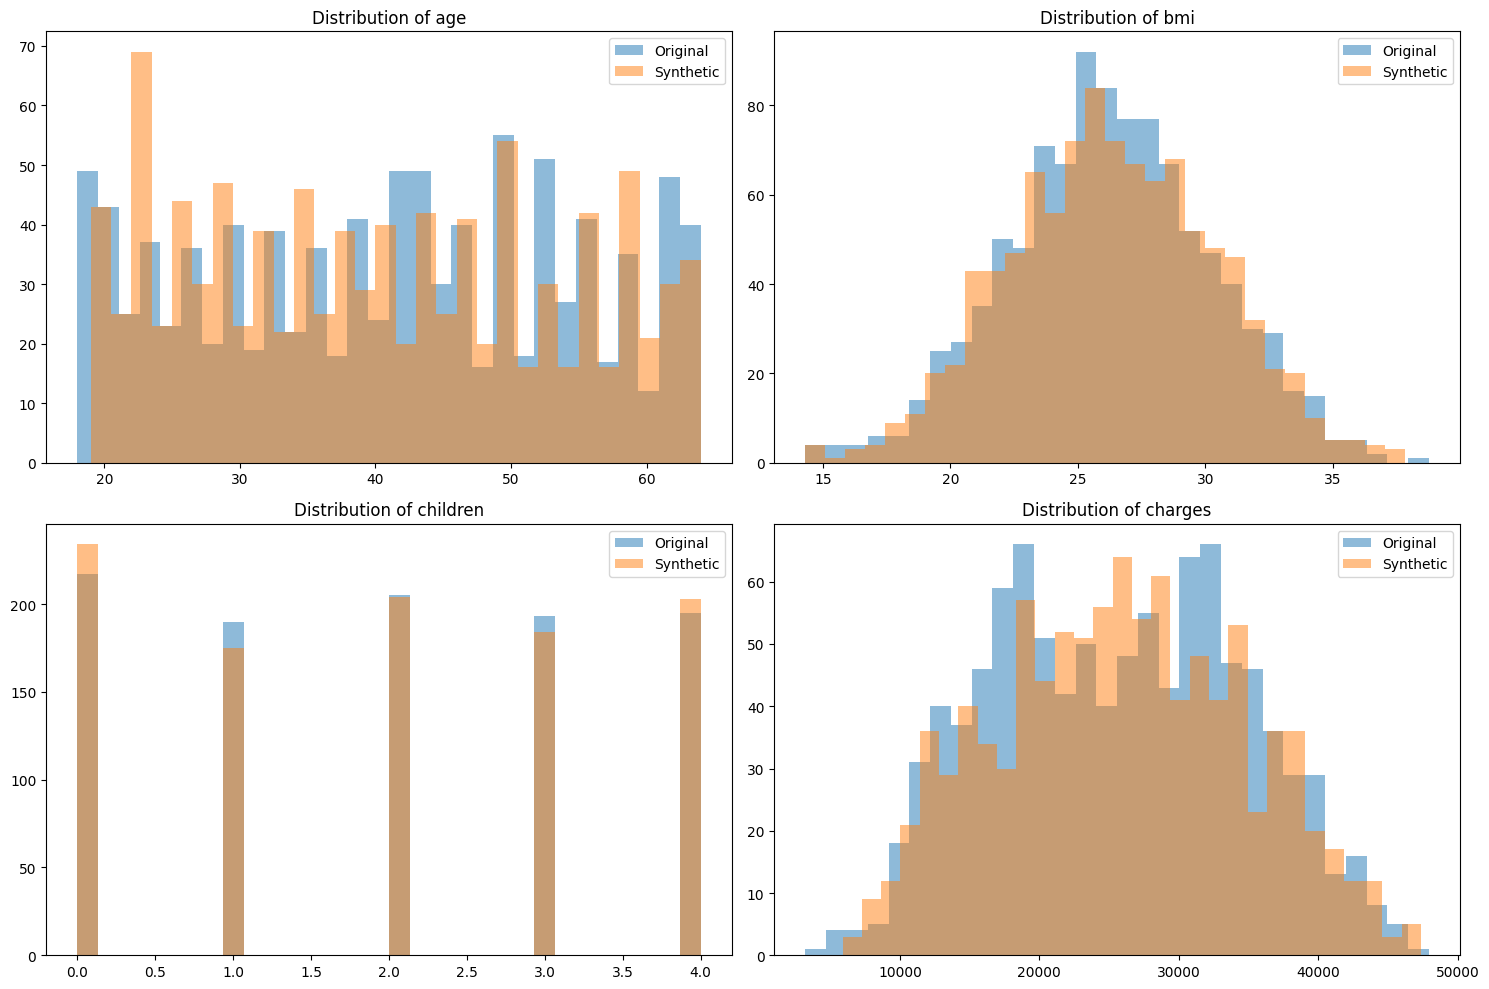

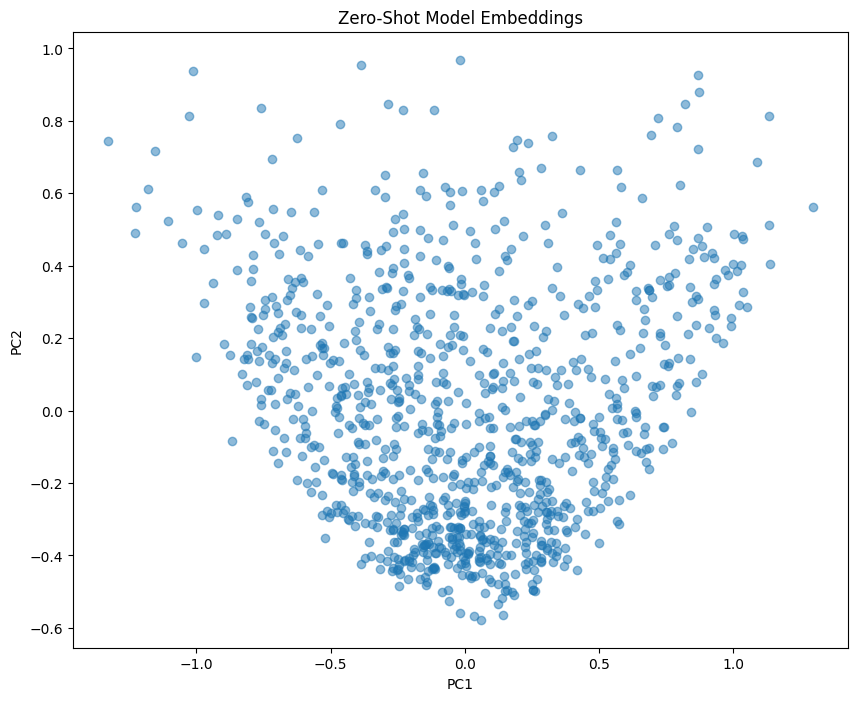


Regression predictions (estimated charges) for first 5 synthetic samples:
[[ 0.00147476]
 [-0.00202405]
 [-0.00658028]
 [-0.02598255]
 [ 0.01654907]]

Classification probabilities (e.g., smoker probability) for first 5 synthetic samples:
[[0.52504754 0.4749525 ]
 [0.530635   0.46936497]
 [0.5315373  0.46846265]
 [0.5183826  0.48161736]
 [0.5303203  0.4696798 ]]

Results saved to disk.


In [21]:
# Install required packages
!pip install sdv pandas numpy torch scikit-learn matplotlib

import pandas as pd
import numpy as np
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn

# Create sample insurance dataset
def create_sample_insurance_data(n_samples=1000):
    np.random.seed(42)

    data = {
        'age': np.random.randint(18, 65, n_samples),
        'sex': np.random.choice(['male', 'female'], n_samples),
        'bmi': np.random.normal(26, 4, n_samples),
        'children': np.random.randint(0, 5, n_samples),
        'smoker': np.random.choice(['yes', 'no'], n_samples),
        'region': np.random.choice(['northeast', 'northwest', 'southeast', 'southwest'], n_samples),
        'charges': np.random.normal(13000, 5000, n_samples)
    }

    data['charges'] += (data['age'] * 100 +
                       (data['bmi'] - 25) * 200 +
                       (data['children'] * 500) +
                       np.where(data['smoker'] == 'yes', 15000, 0))

    return pd.DataFrame(data)

# Generate synthetic data using SDV
def generate_synthetic_data(df, n_samples):
    # Create and detect metadata
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=df)

    # Initialize and fit synthesizer
    synthesizer = GaussianCopulaSynthesizer(metadata)
    synthesizer.fit(df)

    # Generate synthetic data
    synthetic_data = synthesizer.sample(num_rows=n_samples)
    return synthetic_data, synthesizer

# Rest of the code remains the same
# [Previous TabularZeroShotModel class and other functions remain unchanged]

def main():
    # Create and save original data
    print("Creating sample insurance data...")
    original_df = create_sample_insurance_data(1000)
    original_df.to_csv('insurance_data.csv', index=False)
    print("Sample size:", len(original_df))

    # Generate synthetic data
    print("\nGenerating synthetic data...")
    synthetic_data, synthesizer = generate_synthetic_data(original_df, 1000)

    # Prepare data
    df_scaled, scaler = prepare_data(original_df)

    # Initialize model
    input_dim = df_scaled.shape[1]
    model = TabularZeroShotModel(input_dim)

    # Zero-shot inference
    synthetic_scaled, _ = prepare_data(synthetic_data)
    synthetic_tensor = torch.tensor(synthetic_scaled.values[:5], dtype=torch.float32)

    print("\nPerforming zero-shot inference...")
    model.eval()
    with torch.no_grad():
        reg_preds = model(synthetic_tensor, task='regression')
        class_preds = model(synthetic_tensor, task='classification')
        class_probs = torch.softmax(class_preds, dim=1)
        embeddings = model.encoder(torch.tensor(df_scaled.values, dtype=torch.float32))

    # Visualizations
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA

    # Compare distributions
    numerical_cols = ['age', 'bmi', 'children', 'charges']
    fig = plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(2, 2, i)
        plt.hist(original_df[col], alpha=0.5, label='Original', bins=30)
        plt.hist(synthetic_data[col], alpha=0.5, label='Synthetic', bins=30)
        plt.title(f'Distribution of {col}')
        plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot embeddings
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings.numpy())

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
    plt.title('Zero-Shot Model Embeddings')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

    # Print predictions
    print("\nRegression predictions (estimated charges) for first 5 synthetic samples:")
    print(reg_preds.numpy())

    print("\nClassification probabilities (e.g., smoker probability) for first 5 synthetic samples:")
    print(class_probs.numpy())

    return model, synthetic_data, original_df

if __name__ == "__main__":
    model, synthetic_data, original_data = main()

    # Save results
    torch.save(model.state_dict(), 'zero_shot_model.pth')
    synthetic_data.to_csv('synthetic_data.csv', index=False)
    print("\nResults saved to disk.")

# **RDL and relbench**

In [23]:
# Install required packages
!pip install torch torch_geometric scikit-learn numpy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Simple GNN model
class SimpleGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(SimpleGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return x

# Load and prepare data
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load data
data = fetch_california_housing()
X = data.data
y = data.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a simple graph structure (connecting nearby points)
def create_graph(X, k=5):
    from sklearn.neighbors import kneighbors_graph
    adj_matrix = kneighbors_graph(X, n_neighbors=k, mode='connectivity')
    edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)
    return edge_index

# Create graphs for train and test
edge_index_train = create_graph(X_train_scaled)
edge_index_test = create_graph(X_test_scaled)

# Convert to torch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

# Initialize model, optimizer, and loss function
model = SimpleGNN(input_dim=X.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    out = model(X_train_tensor, edge_index_train)
    loss = criterion(out, y_train_tensor)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        # Evaluation
        model.eval()
        with torch.no_grad():
            train_pred = model(X_train_tensor, edge_index_train)
            test_pred = model(X_test_tensor, edge_index_test)

            train_mse = mean_squared_error(y_train_tensor.numpy(), train_pred.numpy())
            test_mse = mean_squared_error(y_test_tensor.numpy(), test_pred.numpy())

            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'Train MSE: {train_mse:.4f}')
            print(f'Test MSE: {test_mse:.4f}')
            print('-' * 30)

# Final evaluation
model.eval()
with torch.no_grad():
    train_pred = model(X_train_tensor, edge_index_train)
    test_pred = model(X_test_tensor, edge_index_test)

    train_mse = mean_squared_error(y_train_tensor.numpy(), train_pred.numpy())
    test_mse = mean_squared_error(y_test_tensor.numpy(), test_pred.numpy())

    train_r2 = r2_score(y_train_tensor.numpy(), train_pred.numpy())
    test_r2 = r2_score(y_test_tensor.numpy(), test_pred.numpy())

    print('\nFinal Results:')
    print(f'Train MSE: {train_mse:.4f}')
    print(f'Test MSE: {test_mse:.4f}')
    print(f'Train R2 Score: {train_r2:.4f}')
    print(f'Test R2 Score: {test_r2:.4f}')

Epoch 10/50:
Train MSE: 1.0931
Test MSE: 1.1997
------------------------------
Epoch 20/50:
Train MSE: 0.8580
Test MSE: 0.9261
------------------------------
Epoch 30/50:
Train MSE: 0.6517
Test MSE: 0.7175
------------------------------
Epoch 40/50:
Train MSE: 0.5784
Test MSE: 0.6361
------------------------------
Epoch 50/50:
Train MSE: 0.5477
Test MSE: 0.6097
------------------------------

Final Results:
Train MSE: 0.5477
Test MSE: 0.6097
Train R2 Score: 0.5903
Test R2 Score: 0.5347
